<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/01_gradient_descent_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gradient Descent Fundamentals

In this notebook we will start by looking at the Linear Regression model, one of the simplest models there is. We will discuss two very different ways to train it:

- Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).
- Using an iterative optimization approach called Gradient Descent (GD) that
gradually tweaks the model parameters to minimize the cost function over the
training set, eventually converging to the same set of parameters as the first
method.


##Setup

In [1]:
# Common imports
import numpy as np
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##Normal Equation

To find the value of $\theta$ that minimizes the cost function, there is a closed-form solution —in other words, a mathematical equation that gives the result directly. This is called the Normal Equation.

$$\hat\theta = (X^TX)^{-1}X^Ty $$

Where:
- $\hat\theta$ is the value of $\theta$ that minimizes the cost function
- $y$ is the vector of target values containing $y^{(i)}$ to $y^{(m)}$

Let’s generate some linear-looking data(100 sample only) to test this equation.

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [4]:
X.shape, y.shape

((100, 1), (100, 1))

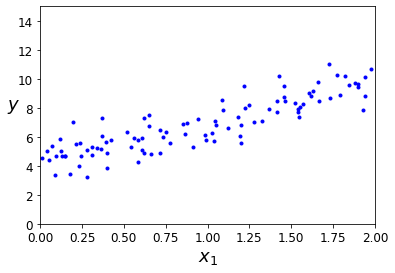

In [5]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Now let’s compute $\theta$ using the Normal Equation. We will use the `inv()` function from NumPy’s linear algebra module (`np.linalg`) to compute the inverse of a matrix, and the `dot()` method for matrix multiplication:

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The function that we used to generate the data is $y = 4 + 3x_1$ + Gaussian noise.

In [7]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 4.215$ and $\theta_1 = 2.770$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using $\hat\theta$.

In [8]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_pred = X_new_b.dot(theta_best)
y_pred

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions.

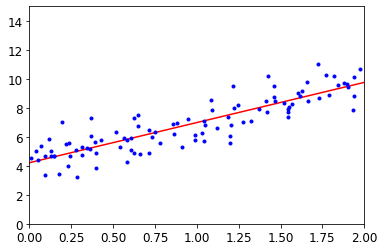

In [10]:
plt.plot(X_new, y_pred, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

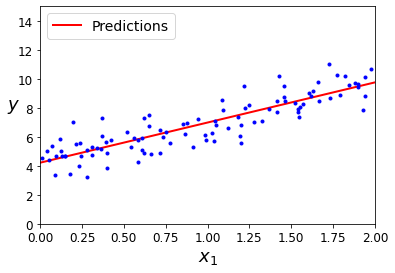

In [11]:
plt.plot(X_new, y_pred, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple.

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [13]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The LinearRegression class is based on the `scipy.linalg.lstsq()` function (the
name stands for “least squares”), which you could call directly:

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\theta = X^+y$, where $X^+$ is the pseudoinverse of X (specifically, the Moore-Penrose inverse). 

You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [15]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **Singular Value Decomposition(SVD)** that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $UΣ V^⊺$. The pseudoinverse is computed as $X^+ = VΣ^+U^⊺$.

This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix $X^⊺X$ is not invertible (i.e., singular), such as if $m < n$ or if some
features are redundant, but the pseudoinverse is always defined.

##Computational Complexity

The Normal Equation computes the inverse of $X^⊺X$, which is an $(n + 1) × (n + 1)$ matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. 

In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

The SVD approach used by Scikit-Learn’s LinearRegression class is about $O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4.

>Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regard to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), predictions are very fast.

So we need different way to train a Linear Regression model, which is
better suited for cases where there are a large number of features or too many training instances to fit in memory.

And it could be achieved by **Gradient Descent**.

##Gradient Descent